# Проект для «Викишоп» 

**Описание компании:** Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Цель:** Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Шаги по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Примечание:** Для выполнения проекта применять *BERT* необязательно, но его можно попробовать..

# Описание данных

Данные находятся в файле `toxic_comments.csv`. 

    Столбец "text" в нём содержит текст комментария, 
    а "toxic" — целевой признак.

## Подготовка

### Импортируем нужные библиотеки

In [1]:
# Импортируем нужные библиотеки

!pip3 install tokenization

from nltk.corpus import wordnet
from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow import keras
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
# from transformers import BertTokenizer, BertForMaskedLM, BertModel, BertConfig
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

import transformers
import pandas as pd 
import numpy as np
import torch
import tqdm
import warnings
import tensorflow as tf
import re
import pymorphy2
import itertools  
import nltk
import sys
import codecs
import tokenization

nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Прочтем через блок try-except наш датасет

In [2]:
# Прочтем через блок try-except наш датасет
try:
    df = pd.read_csv("/datasets/toxic_comments.csv") 
except FileNotFoundError :
    print("FileNotFoundError: Проверьте корректность пути к файлу или наличие самого файла в каталоге!")

### Выведем 5 первых и последних строк через методы head и tail

In [3]:
# Выведем 5 первых 
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


### Выведем 5 последних

In [4]:
# Выведем 5 последних
df.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


### Просмотрим информацию об датасете

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


### Проверим количество пропусков в датасете

In [6]:
# Проверим кол-во пропусков в датасете
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

### Просмотрим статистики наших признаков

In [7]:
# Просмотрим статистики наших признаков
df.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


### Визуализируем наши данные 

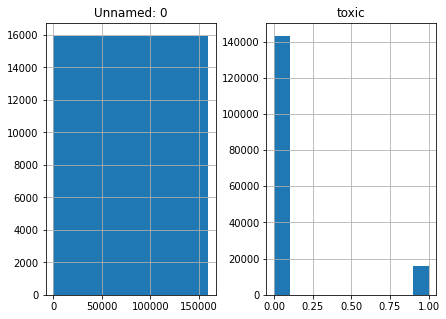

In [8]:
df.hist(figsize=(7,5));

### Уберем незначительный признак "Unnamed: 0"

In [9]:
# Уберем незначительный признак "Unnamed: 0"
df = df.drop(["Unnamed: 0"], axis=1)

### Выводы по подготовке и первичному анализу


    1. Видем, что у целевого признака "toxic" явный дисбаланс
    2. В данных нет нулевых значений, тип данных корректный у всех признаков
    3. В данных есть незначимый признак "Unnamed: 0"
    4. Текст англоязычный 

****

# Лематизация

In [10]:
# лемматизатор NLTK
lemmatizer = WordNetLemmatizer()

# Добавим стоп-слова 

In [11]:
# Добавим стоп-слова
nltk.download('stopwords')
stop_words_my = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Создадим копию нашего датасета

In [12]:
# Создадим копию нашего датасета
df_copy = df.copy()

# Создадим нашу фунцию для лематизации строк и очистки символов (исключение стоп-слов)

In [13]:
%%time

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemm_list  = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    lemm_text = "".join(lemm_list)
    return lemm_text

def clear_text(text):
    f = re.sub(r'[^A-Za-z]', ' ', text) 
    f = f.split()
    return " ".join(f)

df_copy['lemma_morf'] = 0
df_copy['lemma_morf'] = df_copy['text'].apply(lambda x: lemmatize(clear_text(x)))

CPU times: user 17min 46s, sys: 1min 45s, total: 19min 32s
Wall time: 19min 36s


In [14]:
df_copy

,text,toxic,lemma_morf
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,And for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That be a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there no actual article for prosti...
159290,And it looks like it was actually you who put ...,0,And it look like it be actually you who put on...


# Обозначим наши признаки на фичи и целевой признак, а также в соотношении 80:20 поделим на обучающую и тестовую выборку

In [15]:
# признаки-фичи
features = df_copy['lemma_morf']
# целовой признак 
target = df_copy['toxic']

# разделение 
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42)

# Проверим корректность разделения наших выборок

In [16]:
print('X_train {},  y_train {}'.format(X_train.shape, y_train.shape))
print('X_test {},  y_test {}'.format(X_test.shape, y_test.shape))

X_train (143362,),  y_train (143362,)
X_test (15930,),  y_test (15930,)


# Инициализируем CountVectorizer

In [18]:
count_vector = CountVectorizer(min_df=0.001, max_df=.999)

In [19]:
bow_x_train = count_vector.fit_transform(X_train)
bow_x_test = count_vector.transform(X_test)

In [20]:
bow_x_train

<143362x3208 sparse matrix of type '<class 'numpy.int64'>'
	with 5087694 stored elements in Compressed Sparse Row format>

# Инициализируем TfidfVectorizer

In [21]:
counter_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'))
x_train_tf_idf = counter_tf_idf.fit_transform(X_train)
x_test_tf_idf = counter_tf_idf.transform(X_test)

****

# LogisticRegression Model

**Через кроссвалидацию проведем оценку f1_score**

In [22]:
%%time
model = LogisticRegression(C=5.0, random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000) 

scores_list = cross_val_score(estimator=model, 
                              X=x_train_tf_idf, 
                              y=y_train, 
                              cv=5,  
                              scoring='f1')

val_score = scores_list.mean()
print("F1_Score на валидационной выборке", val_score)

F1_Score на валидационной выборке 0.7586777063379914
CPU times: user 49.7 s, sys: 54.4 s, total: 1min 44s
Wall time: 2min 8s


# LinearSVC Model

**Через оптимизатор GridSearchCV подберем оптимальые гиперпараметры**

In [23]:
%%time

from sklearn.svm import LinearSVC

model_svc = LinearSVC()

param_grid_svc = {'C':[0.5, 1.0], 
                  'class_weight':['balanced']}

grid = GridSearchCV(model_svc, param_grid_svc, refit = True, verbose=2, n_jobs=-1, scoring='f1')

grid.fit(x_train_tf_idf, y_train)

print('best params', grid.best_params_)
print('best score', grid.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .......................C=0.5, class_weight=balanced; total time=   5.2s
[CV] END .......................C=0.5, class_weight=balanced; total time=   5.2s
[CV] END .......................C=0.5, class_weight=balanced; total time=   5.3s
[CV] END .......................C=0.5, class_weight=balanced; total time=   5.2s
[CV] END .......................C=0.5, class_weight=balanced; total time=   5.5s
[CV] END .......................C=1.0, class_weight=balanced; total time=   8.4s
[CV] END .......................C=1.0, class_weight=balanced; total time=   8.2s
[CV] END .......................C=1.0, class_weight=balanced; total time=   7.1s
[CV] END .......................C=1.0, class_weight=balanced; total time=   7.0s
[CV] END .......................C=1.0, class_weight=balanced; total time=   7.5s
best params {'C': 0.5, 'class_weight': 'balanced'}
best score 0.7562427304455508
CPU times: user 35.4 s, sys: 198 ms, total: 35.6 

# Проверка лучшей модели на тесте

In [25]:
model_linear_svc = LinearSVC(class_weight='balanced', C=0.5).fit(x_train_tf_idf, y_train)
y_pred = model_linear_svc.predict(x_test_tf_idf) 
print("F1_score:", f1_score(y_pred, y_test))

F1_score: 0.7666476949345475


****

# Заключительные выводы по проекту TF-IDF

**Выводы по подготовке и первичному анализу:**

    1. Видем, что у целевого признака "toxic" явный дисбаланс
    2. В данных нет нулевых значений, тип данных корректный у всех признаков
    3. В данных есть незначимый признак "Unnamed: 0"
    4. Текст англоязычный 

**Выводы по обучению моделей TF-IDF:**

    1. Произвели лемматизацию текста и инициализировали  TfidfVectorizer и CountVectorizer
    2. Произвели разделение на обучающую и тестовую выборки, проверена корректность разделения
    3. В качестве моделей были выбранны: LinearSVC и LogisticRegression Model
    4. F1score наилучшей модели на тесте : 0.7666476949345475
    5. Наилучшая модель - Suport Vector Machine (Linear SVC)  
    6. Вывели, что TfidfVectorizer доводит после уравневания нашего целевого признака до нужной нам оценки, в отличии от CountVectorizer
    7. Если не балансировать нашу целевую переменную, то результат нашей метрики будет лучше.

****